# European Option Pricing

使用 QuantLib Python 對歐式選擇權進行定價，使用的方法包括 Black-Scholes-Merton 公式和二元樹法。

In [10]:
import QuantLib as ql
import matplotlib.pyplot as plt
%matplotlib inline

設定一個 AAPL 的歐式買權選擇權，設定條件包括行使價格、到期日、現貨價格、波動度、股息殖利率等，這些數值都是根據真實市場數據設定的。

In [11]:
maturity_date = ql.Date(15, 1, 2016)
spot_price = 127.62
strike_price = 130
volatility_rate = 0.2
dividend_rate = 0.0163
option_type = ql.Option.Call

risk_free_rate = 0.001
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)

calculation_date = ql.Date(8, 5, 2015)
ql.Settings.instance().evaluationDate = calculation_date

創建歐式選擇權對象：

In [12]:
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise  = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

## 使用 Black-Scholes-Merton 的選擇權定價過程：

In [13]:
spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))

flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, day_count))

dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_rate, day_count))

flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, volatility_rate, day_count))

bsm_process = ql.BlackScholesMertonProcess(spot_handle,
                                            dividend_yield,
                                            flat_ts,
                                            flat_vol_ts)

用 AnalyticEuropeanEngine 計算理論價格：

In [14]:
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
bs_price = european_option.NPV()
print("The theoretical price is: ", bs_price)

The theoretical price is:  6.749271812460607


## 使用二元樹法計算價格，並將兩種方法的結果進行對比：

In [15]:
def binorimal_price(bsm_process, steps):
    # Cox-Ross-Rubinstein（CRR）上升因子和下降因子可以用下列公式計算：
    # u = exp(σ*sqrt(Δt))
    # d = 1/u, 其中，σ是資產價格的波動性，Δt是每個時間步長。
    binorimal_engine = ql.BinomialVanillaEngine(bsm_process, "crr", steps)
    european_option.setPricingEngine(binorimal_engine)
    return european_option.NPV()

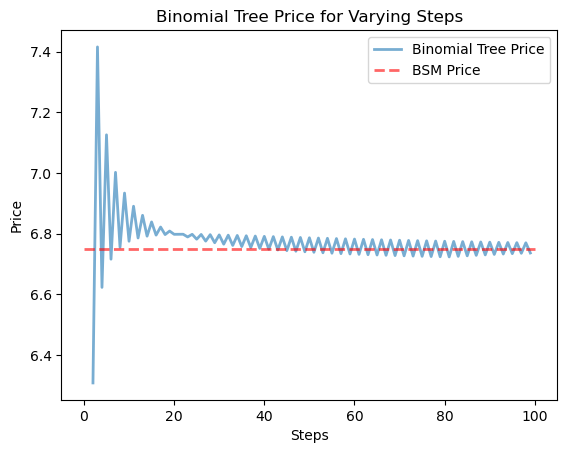

In [17]:
steps = range(2, 100, 1)
prices = [binorimal_price(bsm_process, step) for step in steps]
plt.plot(steps, prices, label="Binomial Tree Price", lw=2, alpha=0.6)
plt.plot([0, 100], [bs_price, bs_price], 'r--', label="BSM Price", lw=2, alpha=0.6)
plt.xlabel("Steps")
plt.ylabel("Price")
plt.title("Binomial Tree Price for Varying Steps")
plt.legend()

## 核心概念

在於將 Black-Scholes-Merton 的定價法和二元樹法進行對比，兩種方法分別基於理論和數值運算，透過比較可以觀察到二元樹法隨著計算步數的增加，選擇權價格會逐漸收斂於理論價格。

二元樹定價模型和Black-Scholes-Merton (BSM)模型都是對期權定價的工具，但是他們的方法和假設有所不同。當我們在二元樹模型中增加計算步數時，該模型的結果將趨近於BSM模型的結果。下面是其中的原因：

1. 二元樹模型的局限性：二元樹模型的一個主要局限性是它假設未來資產價格只能在每個時間步長達到兩個可能的價值。這是一種簡化，而實際上，資產價格可以在每個時間點達到無窮多的價值。
2. 增加步數的影響：隨著我們增加二元樹模型的步數，每步的價格變動將變得越來越小，所以模型將更好地模擬資產價格的連續變動。因此，隨著步數的增加，二元樹模型的結果將更接近於基於連續資產價格變動的BSM模型的結果。
3. 極限行為：實際上，可以證明當二元樹模型的步數趨近於無窮大時，它的結果將收斂於BSM模型的結果。這是因為當步數無窮大時，二元樹模型實質上變成了BSM模型的一種數值解法。
總的來說，隨著二元樹模型步數的增加，模型的結果將趨近於BSM模型的結果，這是因為二元樹模型越來越好地模擬了資產價格的連續變動，並且在極限情況下，二元樹模型實質上變成了BSM模型的一種數值解法。